# **DELTA** 
### First Assignment by Alina Müller 596339

This notebook provides an approach for predicting the 


Your task is to predict the trading volume of a certain asset. In the train dataset you can find 320 latent features derived from the original time series. Furthermore, the last column of the training dataset is the one-day ahead trading volume of the asset, which you should forecast. In the test time series, you have access only to the 320 latent time series derived from the original attributes on the testing period.  

Before we get started, let's import the necessary libraries.

In [2]:
import pandas as pd
from tensorflow import keras  #type:ignore
from tensorflow.keras import layers #type:ignore
from tensorflow.keras.models import Sequential #type:ignore
from tensorflow.keras.layers import Dense #type:ignore
from tensorflow.keras.layers import Input #type:ignore
from tensorflow.keras.layers import BatchNormalization #type:ignore 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD #type:ignore
import keras
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
from scikeras.wrappers import KerasRegressor 
from sklearn.model_selection import GridSearchCV

import the data into a Pandas data frame

In [3]:
df = pd.read_csv(r'C:\Users\User\Desktop\UNI\Python\Delta\DELTA\Train_Time_Series.csv')
print(df.describe())
#val_df = pd.read_csv(r'C:\Users\User\Desktop\UNI\Python\Delta\DELTA\Test_Time_Series.csv')

              Date             0             1             2             3  \
count  2103.000000  2.103000e+03  2.103000e+03  2.103000e+03  2.103000e+03   
mean   1051.000000  5.592012e+11  6.089298e+11  5.607740e+10 -1.102054e+12   
std     607.228128  4.081145e+11  4.456878e+11  4.271146e+10  8.127120e+11   
min       0.000000  1.296695e+10  1.457465e+10  6.406918e+08 -3.148953e+12   
25%     525.500000  2.161836e+11  2.419178e+11  1.914610e+10 -1.701718e+12   
50%    1051.000000  5.551009e+11  6.085136e+11  5.408890e+10 -1.110798e+12   
75%    1576.500000  8.715457e+11  9.301602e+11  8.742076e+10 -4.307658e+11   
max    2102.000000  1.513638e+12  1.686452e+12  1.536908e+11 -2.651554e+10   

                  4             5             6             7             8  \
count  2.103000e+03  2.103000e+03  2.103000e+03  2.103000e+03  2.103000e+03   
mean   8.901960e+11 -3.766310e+11  2.046639e+11 -9.497923e+10 -1.339407e+12   
std    6.532922e+11  2.778580e+11  1.500170e+11  7.221703e+1

#### A First Look at the Data


In [4]:
print('Dimensionality of the train data is {}.'.format(df.shape)) 
print('The total number of elements is {}.'.format(df.size))
print('Count of missing values in train data is {}.'.format(df.isna().sum().sum()))


# print('Dimensionality of the test data is {}.'.format(val_df.shape)) 
# print('The total number of elements is {}.'.format(val_df.size))
# print('Count of missing values in test data is {}.'.format(val_df.isna().sum().sum()))

df.set_index('Date')
#val_df.set_index('Date')



Dimensionality of the train data is (2103, 322).
The total number of elements is 677166.
Count of missing values in train data is 0.


,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,Trading Volume (Target Variable)
Date,,,,,,,,,,,,,,,,,,,,,
0,1.296695e+10,1.457547e+10,1.325288e+09,-2.655211e+10,2.101698e+10,-9.094024e+09,4.858148e+09,-2.356104e+09,-3.233936e+10,5.018100e+09,...,-1.644660e+10,9.440106e+09,1.541441e+10,1.119134e+10,4.934779e+09,-1.751067e+09,5.676475e+09,3.468865e+10,-2.065788e+10,7.780059e+06
1,1.296838e+10,1.457465e+10,1.328991e+09,-2.655095e+10,2.115096e+10,-9.086957e+09,4.913736e+09,-2.354550e+09,-3.234193e+10,5.018558e+09,...,-1.773644e+10,9.416437e+09,1.545443e+10,1.118869e+10,4.936015e+09,-1.749437e+09,5.694470e+09,3.467851e+10,-2.066140e+10,7.454554e+06
2,1.305118e+10,1.463240e+10,1.306612e+09,-2.651588e+10,2.114048e+10,-9.094517e+09,4.919696e+09,-2.304025e+09,-3.232356e+10,5.047141e+09,...,-1.761549e+10,9.425556e+09,1.552926e+10,1.119478e+10,4.963428e+09,-1.776820e+09,5.702848e+09,3.468841e+10,-2.067423e+10,2.945997e+07
3,1.381830e+10,1.516195e+10,1.151668e+09,-2.651554e+10,2.114120e+10,-9.052058e+09,4.983555e+09,-1.998877e+09,-3.232600e+10,5.303193e+09,...,-1.756951e+10,9.640630e+09,1.571777e+10,1.107390e+10,5.225323e+09,-2.073629e+09,5.731859e+09,3.500143e+10,-2.045206e+10,1.363032e+07
4,1.376322e+10,1.527571e+10,1.281023e+09,-2.670474e+10,2.122595e+10,-9.091410e+09,5.032221e+09,-2.144453e+09,-3.253045e+10,5.302928e+09,...,-1.753090e+10,9.775995e+09,1.571977e+10,1.129186e+10,5.128488e+09,-2.067993e+09,5.317616e+09,3.692245e+10,-2.049799e+10,9.224730e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,1.498789e+12,1.684459e+12,1.523036e+11,-3.043224e+12,2.423148e+12,-1.041245e+12,5.655618e+11,-2.764383e+11,-3.731398e+12,5.842558e+11,...,-1.963215e+12,1.030373e+12,1.779354e+12,1.211987e+12,5.676650e+11,-2.058546e+11,6.612487e+11,4.025992e+12,-2.358453e+12,1.650919e+07
2099,1.499692e+12,1.684857e+12,1.519832e+11,-3.037436e+12,2.433320e+12,-1.042046e+12,5.713076e+11,-2.745027e+11,-3.744935e+12,5.833355e+11,...,-2.035620e+12,1.027042e+12,1.791622e+12,1.213902e+12,5.680250e+11,-2.047516e+11,6.622134e+11,4.024809e+12,-2.366146e+12,1.168145e+07
2100,1.499934e+12,1.684753e+12,1.521760e+11,-3.037404e+12,2.425392e+12,-1.042076e+12,5.670715e+11,-2.731308e+11,-3.748475e+12,5.833163e+11,...,-2.003065e+12,1.055777e+12,1.791569e+12,1.198386e+12,5.682254e+11,-2.048756e+11,6.614618e+11,4.022918e+12,-2.365655e+12,2.940797e+07


In [5]:
# Obtain a high-level overview
df.info()
df.describe().transpose()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103 entries, 0 to 2102
Columns: 322 entries, Date to Trading Volume (Target Variable)
dtypes: float64(321), int64(1)
memory usage: 5.2 MB


,count,mean,std,min,25%,50%,75%,max
Date,2103.0,1.051000e+03,6.072281e+02,0.000000e+00,5.255000e+02,1.051000e+03,1.576500e+03,2.102000e+03
0,2103.0,5.592012e+11,4.081145e+11,1.296695e+10,2.161836e+11,5.551009e+11,8.715457e+11,1.513638e+12
1,2103.0,6.089298e+11,4.456878e+11,1.457465e+10,2.419178e+11,6.085136e+11,9.301602e+11,1.686452e+12
2,2103.0,5.607740e+10,4.271146e+10,6.406918e+08,1.914610e+10,5.408890e+10,8.742076e+10,1.536908e+11
3,2103.0,-1.102054e+12,8.127120e+11,-3.148953e+12,-1.701718e+12,-1.110798e+12,-4.307658e+11,-2.651554e+10
...,...,...,...,...,...,...,...,...
316,2103.0,-7.343662e+10,5.444497e+10,-2.495581e+11,-1.138499e+11,-7.112322e+10,-2.744223e+10,-3.363329e+08
317,2103.0,2.343029e+11,1.723974e+11,4.978714e+09,8.995924e+10,2.323428e+11,3.641901e+11,6.641366e+11
318,2103.0,1.471924e+12,1.071082e+12,3.467851e+10,5.702275e+11,1.482298e+12,2.268702e+12,4.058537e+12
319,2103.0,-8.510057e+11,6.314606e+11,-2.387457e+12,-1.304478e+12,-8.636325e+11,-3.236257e+11,-1.999758e+10


In [6]:
#val_df.describe().transpose()

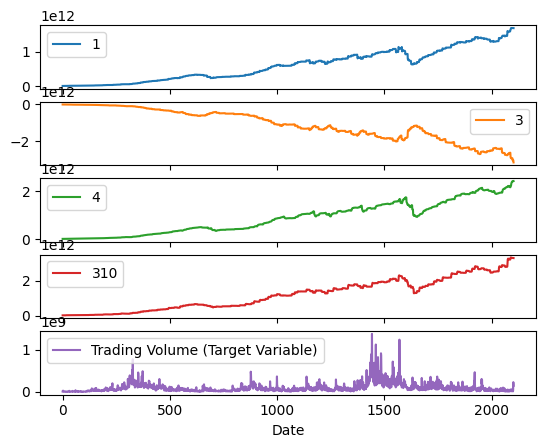

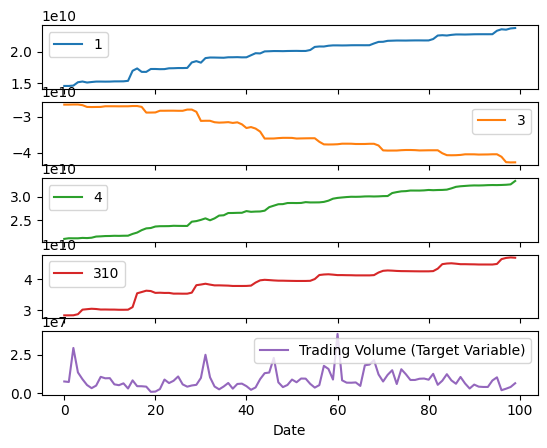

In [7]:
plot_cols = ['1', '3', '4','310', 'Trading Volume (Target Variable)']
plot_features = df[plot_cols]
plot_features.index = df['Date']
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:100]
plot_features.index = df['Date'][:100]
_ = plot_features.plot(subplots=True)

### Split the data


In [8]:
#X = df.drop('Trading Volume (Target Variable)', axis=1)
#y = df['Trading Volume (Target Variable)']
#seed = 888

train_size = int(len(df) * 0.7)
validation_size = int(len(df) * 0.15)

train, validation, test = df[:train_size], df[train_size:train_size + validation_size], df[train_size + validation_size:]

scaler = StandardScaler() 
columns = df.columns  # Store column names before scaling
train = pd.DataFrame(scaler.fit_transform(train), columns=columns)
test = pd.DataFrame(scaler.transform(test), columns=columns)
validation = pd.DataFrame(scaler.transform(validation), columns=columns)



In [9]:
print('Train data shape: ', train.shape)
print('Validation data shape: ', validation.shape)
print('Test data shape: ', test.shape)

Train data shape:  (1472, 322)
Validation data shape:  (315, 322)
Test data shape:  (316, 322)


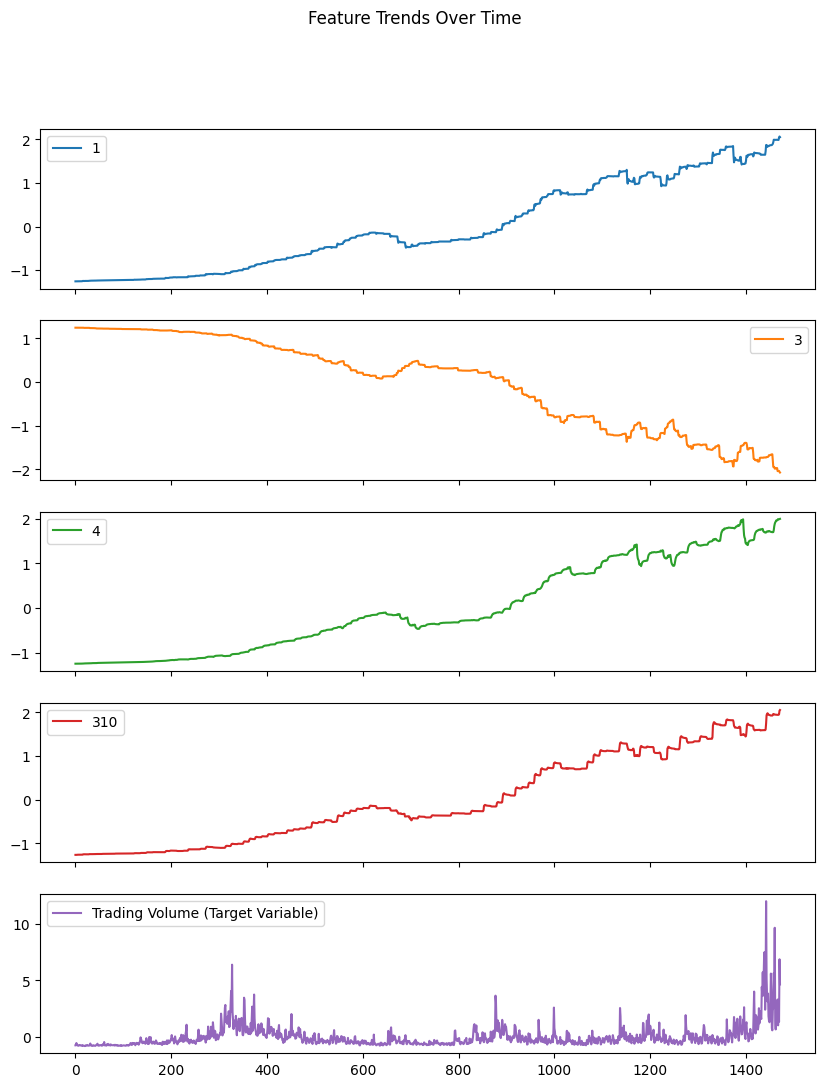

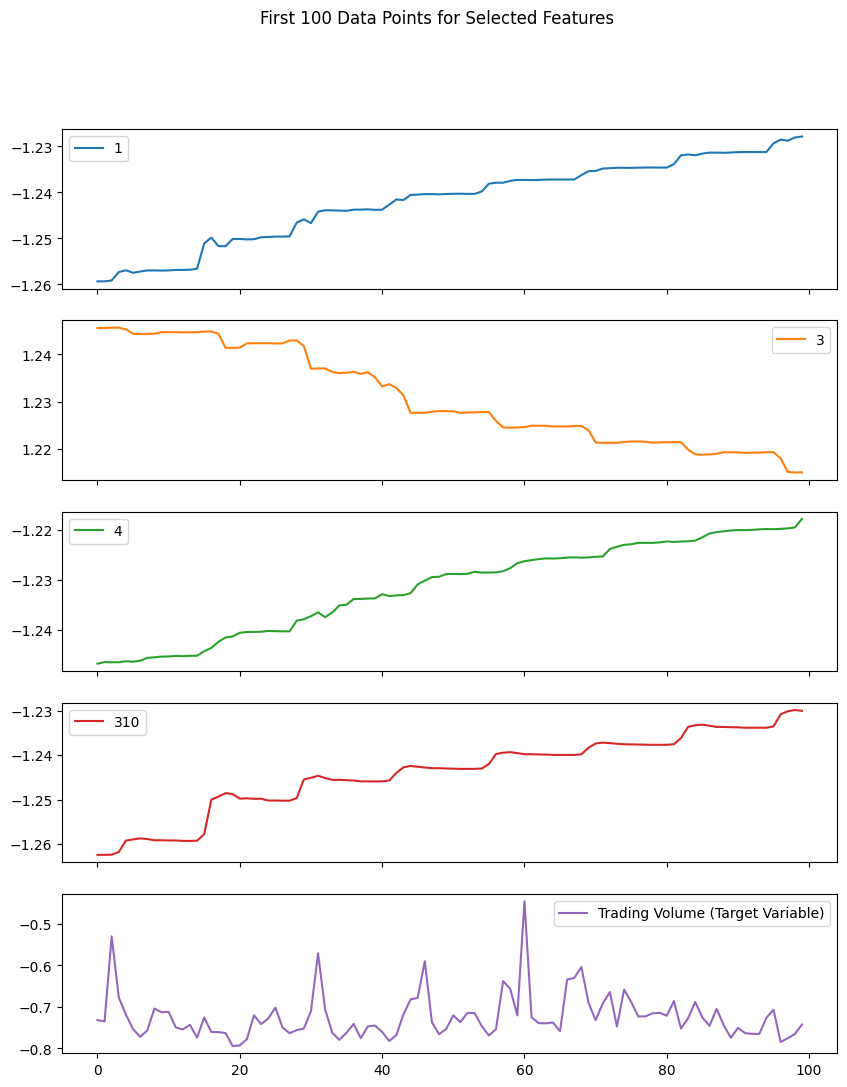

In [10]:
plot_cols = ['1', '3', '4', '310', 'Trading Volume (Target Variable)']
plot_features = train[plot_cols]

# Using Pandas for a simple plot
plot_features.plot(subplots=True, figsize=(10, 12))  # Each column as a subplot
plt.suptitle('Feature Trends Over Time')
plt.show()

# Focusing on the first 100 data points of selected features
plot_features[:100].plot(subplots=True, figsize=(10, 12), title="First 100 Data Points for Selected Features")
plt.show()

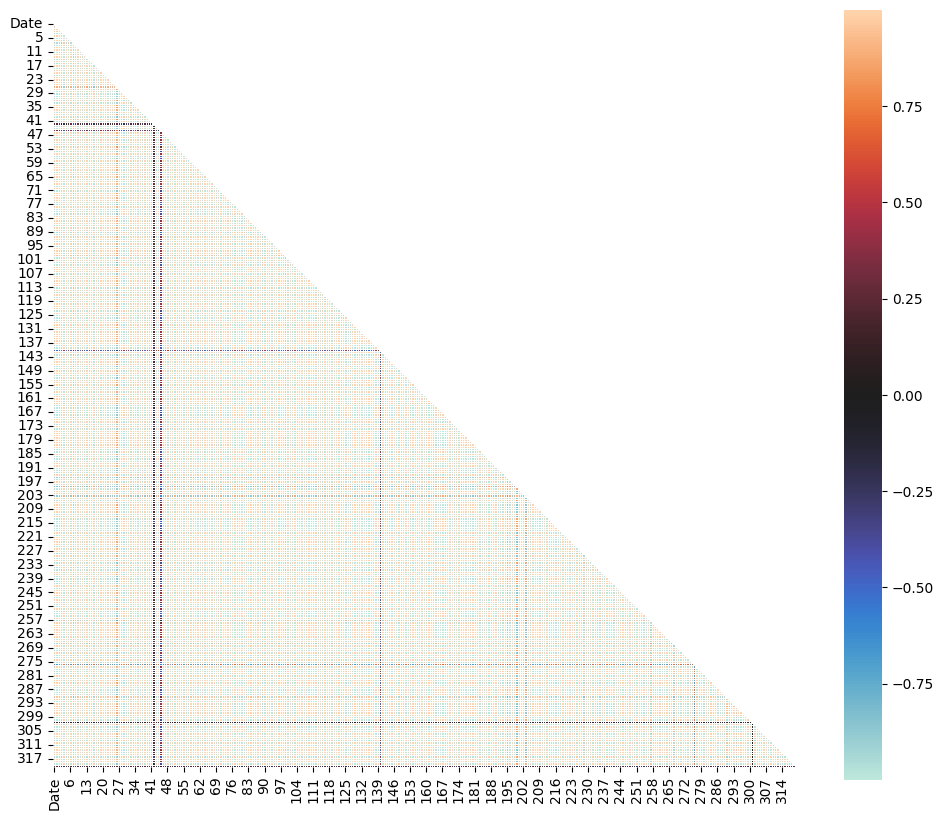

In [11]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, center=0, annot=False, fmt='.2f', square=True, linewidths=.5)
plt.show()

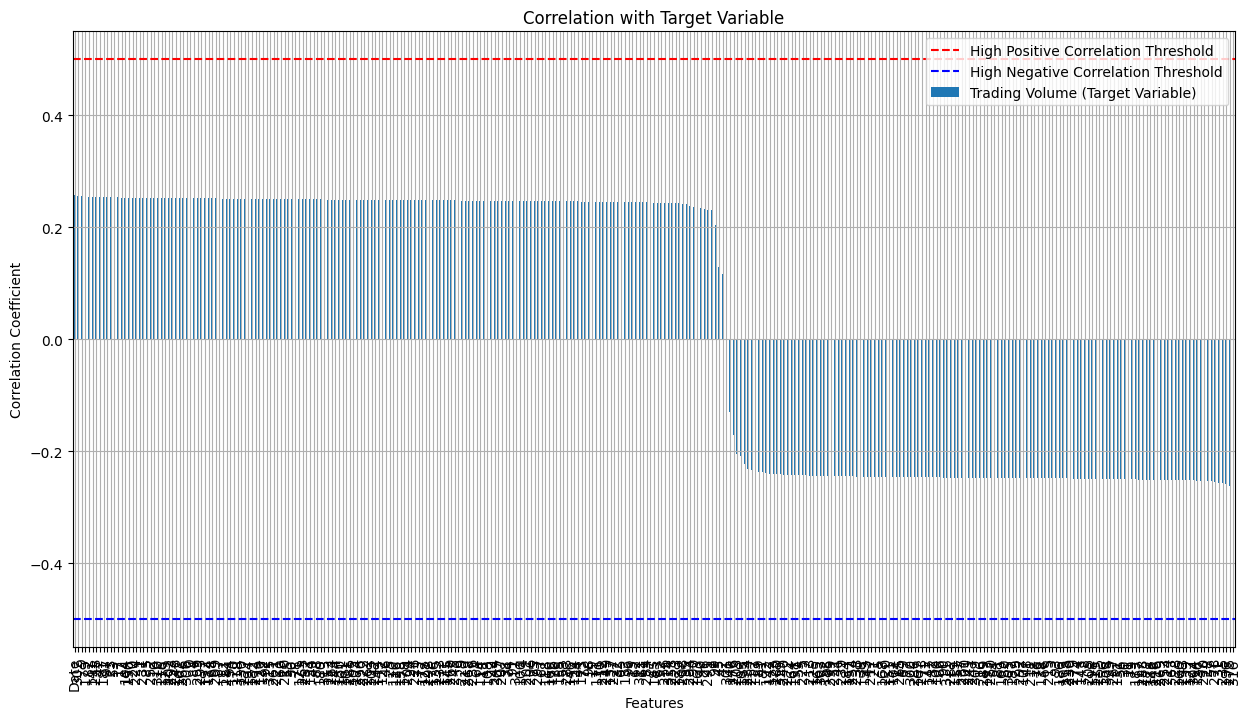

In [12]:
correlation_with_target = correlation_matrix['Trading Volume (Target Variable)']  # Replace 'target' with the actual name of your target variable
correlation_with_target = correlation_with_target.drop('Trading Volume (Target Variable)')
plt.figure(figsize=(15, 8))
correlation_with_target.sort_values(ascending=False).plot(kind='bar')
plt.title('Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0.5, color='r', linestyle='--', label='High Positive Correlation Threshold')
plt.axhline(y=-0.5, color='b', linestyle='--', label='High Negative Correlation Threshold')
plt.legend()
plt.grid(True)
plt.show()
# Filter out columns where the correlation coefficient is between -0.5 and 0.5
columns_to_drop = correlation_with_target[(correlation_with_target >= -0.18) & (correlation_with_target <= 0.18)].index

# Step 3: Drop these columns from the DataFrame
#train_dropped = train.drop(columns=columns_to_drop)

# Print out the remaining columns and the shape of the updated DataFrame
#print("Columns remaining after dropping:", train_dropped.columns)
#print("Shape of the updated DataFrame:", train_dropped.shape)


In [13]:
X_train = train.drop('Trading Volume (Target Variable)', axis=1)
y_train = train['Trading Volume (Target Variable)']

X_val = validation.drop('Trading Volume (Target Variable)', axis=1)
y_val = validation['Trading Volume (Target Variable)']

X_test = test.drop('Trading Volume (Target Variable)', axis=1)
y_test = test['Trading Volume (Target Variable)']

#### 1+2: Number of hidden layers and number of neurons
The number of layers and the number of neurons is a parameter that you would have to decide on.

A deep NN is one with more than one hidden layer, so we will use 2 hidden layers this time.

As to the size of hidden layers, we go for n=128.

In [14]:
param_grid = {
    'units': [32, 64, 128],  # Number of units in the hidden layer
    'activation': ['relu', 'tanh'],  # Activation functions
    'batch_size': [32, 64, 128],  # Sizes of batches for training
    'epochs': [10, 50, 100]  # Number of epochs to train
}

#### 3: activation function
We will go for industry standard which is relu

### Normalize the data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.
It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.


In [15]:
std = np.sqrt(2/(X.shape[1])) 
std


NameError: name 'X' is not defined

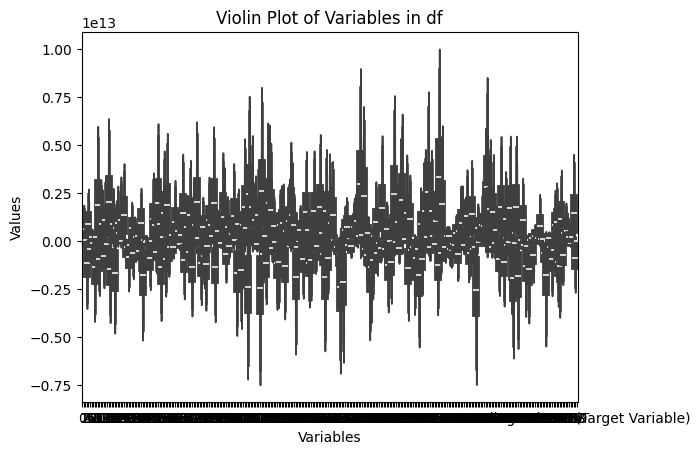

In [ ]:


# Select the variables to plot
variables = df.columns[1:]  # Exclude the 'Date' and 'Trading Volume (Target Variable)' columns

# Create the Violin plot
sns.violinplot(data=df[variables])

# Set the plot title and labels
plt.title('Violin Plot of Variables in df')
plt.xlabel('Variables')
plt.ylabel('Values')

# Show the plot
plt.show()


https://www.tensorflow.org/tutorials/structured_data/time_series

In [20]:

# Redefine the model creation function to include all parameters you want to tune
def create_model(neurons=32, layers=2, activation='relu'):
    model = Sequential()
    model.add(keras.Input(shape=(X_train.shape[1],)))
    model.add(Dense(neurons,  activation=activation))
    for _ in range(1, layers):
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))
    #model.compile(optimizer='adam', loss='mean_squared_error', metrics=['r2_score'])
    return model

# Wrap the model with KerasRegressor
model = KerasRegressor(model=create_model, loss='mean_squared_error', metrics=['r2_score'], verbose=0)  # Default training parameters

# Define the grid search parameters
# param_grid = {
#     #'batch_size': [16, 32, 64],
#     #'epochs': [50, 100],
#     'model__neurons': [16, 32, 64, 128], 
#     'model__layers': [ 2, 3],
#     'model__activation': ['relu', 'tanh']
# }
batch_size = [63, 65]
epochs = [35, 40, 45]
model__layers = [2]
optimizers = [Adam(learning_rate=lr) for lr in [0.001, 0.01, 0.1]] + \
             [SGD(learning_rate=lr, momentum=mom) for lr in [0.01, 0.1] for mom in [0.1, 0.2, 0.4, 0.6]]
#init_mode = ['he_normal', 'he_uniform']
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizers, model__layers=model__layers)#model__init_mode=init_mode,
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=1)

# Fit the grid search model
grid_result = grid.fit(X_train, y_train)

# Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result)

#params = grid_result.cv_results_['params']
#optimizer = grid_result
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % ( param,))

    #BEst:-1.735981 (2.794949) with: {'model__activation': 'tanh', 'model__layers': 2, 'model__neurons': 64}
    #Best: -1.803339 using {'batch_size': 60, 'epochs': 50}
    #Best: -2.354620 using {'batch_size': 60, 'epochs': 40, 'optimizer': 'adam'}
    #Best: -1.638197 using {'batch_size': 60, 'epochs': 50, 'optimizer': 'adam'}
    #Best: -1.598034 using {'batch_size': 65, 'epochs': 40, 'model__layers': 2, 'optimizer': 'sgd'}
    #Best: -1.702402 using {'batch_size': 65, 'epochs': 35, 'model__layers': 3, 'optimizer': 'sgd', 'optimizer__learning_rate': 0.01, 'optimizer__momentum': 0.0}


Fitting 5 folds for each of 66 candidates, totalling 330 fits


c:\Users\user\Desktop\UNI\Python\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [-6.45196647 -5.10760458 -1.3201742  -4.57422397 -5.31960586 -4.85969581
 -4.29782729         nan         nan         nan         nan -5.21429707
 -3.46978696 -5.87226532 -4.52689589 -8.64676986 -5.14659318 -4.14378961
         nan         nan         nan         nan -7.06520752 -7.23062227
 -8.25386673 -4.13537821 -4.00529201 -4.09697424 -8.8736954          nan
         nan         nan         nan -2.85879352 -2.30426094 -1.06847999
 -1.48873245 -5.39421436 -5.23661517 -3.89192988         nan         nan
         nan         nan -3.79019984 -2.00829387 -0.52735205 -2.06581757
 -2.42201209 -3.98749982 -4.80295761         nan         nan         nan
         nan -4.76562941 -6.17626479 -2.210393   -6.31946992 -1.98361061
 -3.27992353 -2.18983667         nan         nan         nan         nan]
  warnings.warn(


Best: -0.527352 using {'batch_size': 65, 'epochs': 40, 'model__layers': 2, 'optimizer': <keras.src.optimizers.adam.Adam object at 0x000002E4D61B1D00>}
GridSearchCV(estimator=KerasRegressor(loss='mean_squared_error', metrics=['r2_score'], model=<function create_model at 0x000002E4D8DD3A60>, verbose=0),
             n_jobs=-1,
             param_grid={'batch_size': [63, 65], 'epochs': [35, 40, 45],
                         'model__layers': [2],
                         'optimizer': [<keras.src.optimizers.adam.Adam object at 0x000002E4DAB8EC30>,
                                       <keras.src.optimizers.adam.Adam object at 0x000002E4D...
                                       <keras.src.optimizers.sgd.SGD object at 0x000002E4D61B2810>]},
             verbose=1)


Using best parameters: {'batch_size': 65, 'epochs': 45, 'model__layers': 2, 'optimizer': 'sgd'}
Epoch 1/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8585 - r2_score: -0.7589 - val_loss: 0.3805 - val_r2_score: -0.5235
Epoch 2/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8832 - r2_score: 0.0642 - val_loss: 1.3852 - val_r2_score: -4.5457
Epoch 3/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8635 - r2_score: 0.0895 - val_loss: 7.3335 - val_r2_score: -28.3602
Epoch 4/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8971 - r2_score: 0.0294 - val_loss: 1.3869 - val_r2_score: -4.5525
Epoch 5/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8493 - r2_score: 0.0738 - val_loss: 4.4080 - val_r2_score: -16.6478
Epoch 6/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9433 - r2_score: 0.1144 - val_loss: 3.1414 - val_r2_score: -11.5770
Epoch 7/45
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9334 - r2_score: 0.0754 - val_loss: 3.3201 - val_r2_score: -12.2923
Epoch 8/45

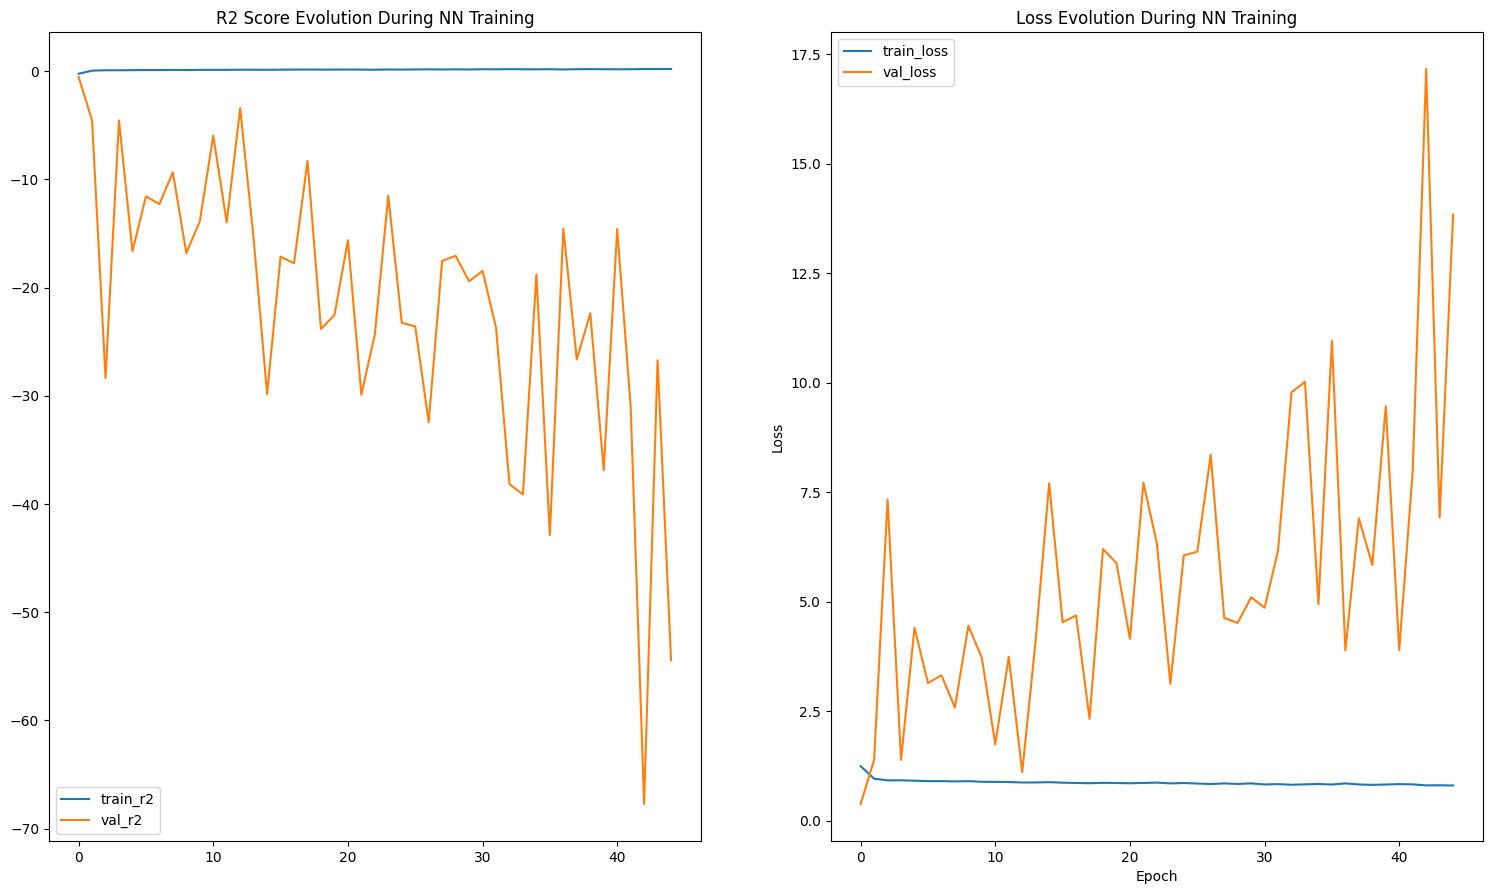

In [191]:
best_params = grid.best_params_
print("Using best parameters:", best_params)
model = Sequential()
model.add(Input(shape=(321,)))
model.add(Dense(best_params.get('model__neurons', 32), activation=best_params.get('model__activation', 'relu')))
for _ in range(1, best_params.get('model__layers',2)):
    model.add(Dense(best_params.get('model__neurons', 32), activation=best_params.get('model__activation', 'relu')))
model.add(Dense(1))
model.compile(optimizer=best_params.get('optimizer', 'sgd'), loss='root_mean_squared_error', metrics=['r2_score'])

# Train the model to capture the history
history = model.fit(X_train, y_train, epochs=best_params.get('epochs', 50), batch_size=best_params.get('batch_size', 32),
                    validation_data=(X_test, y_test), verbose=1)

# Define the plotting function
def show_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    
    # Metrics plot
    ax1.plot(history.history['r2_score'])
    ax1.plot(history.history['val_r2_score'])
    ax1.legend(['train_r2', 'val_r2'], loc='best')
    ax1.set_title('R2 Score Evolution During NN Training')
    
    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(['train_loss', 'val_loss'], loc='best')
    ax2.set_title('Loss Evolution During NN Training')
    plt.show()

# Display the training history graph
show_history(history)

In [ ]:
# Step 1: Model definition function
def create_model(layers=1, neurons=32, activation='relu'):
    model = Sequential()
    model.add(keras.Input(shape=(X.shape[1],)))
    model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
    for i in range(layers - 1):
        model.add(Dense(neurons, activation=activation))
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Wrap the model using KerasRegressor
#model = KerasRegressor(build_fn=create_model, verbose=0)

# Step 2: Define the grid search parameters
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'layers': [1, 2, 3],
    'neurons': [16, 32, 64],
    'activation': ['relu', 'tanh']
}

# Step 3: Create the GridSearchCV object
grid = GridSearchCV(estimator=create_model, param_grid=param_grid, n_jobs=-1, cv=3)

# Step 4: Fit the grid search model
grid_result = grid.fit(X_train, y_train,)

# Step 5: Evaluate the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got <function create_model at 0x000001E2308FCD60> instead.

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(X.shape[1],)))
model.add(layers.Dense(nb_units,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed),  #initialisation of weights; check doc for more options
                bias_initializer='zeros', #initialization of biases, will also be done by default
                )) #first hidden layer size, i.e. number of features
model.add(BatchNormalization())
# One more layer with the same configuration
model.add(layers.Dense(nb_units, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed),bias_initializer='zeros')) 
model.add(layers.Dense(nb_units, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=seed), bias_initializer='zeros')) 
#model.add(BatchNormalization())
model.add(layers.Dense(1)) 
#model.add(BatchNormalization())
model.summary()


# model = Sequential([
#     Dense(nb_units, activation='relu', input_shape=(X_train.shape[1],)),
#     #Dense(64, activation='relu'),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss='mse')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 256 (1.00 KB)

#### 5+6: loss function, learning rate and optimizer
As discussed before, the loss function is defined by the task (mse, binary cross-entropy, etc.), in our case it is cross-entropy. Learning rate is set in the optimizer but does not have to remain the same throughout the training (i.e. AdaGrad).

In [ ]:
# We use SGD as optimizer and cover more options later on
opt = keras.optimizers.Adam(learning_rate=0.15) # there are many more parameters that we could be adding here

# Calling compile and specifying some mandatory arguments completes setting up the NN
model.compile(optimizer=opt, loss='mse', metrics=['r2_score'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,881 (292.50 KB)

 Trainable params: 74,625 (291.50 KB)

 Non-trainable params: 256 (1.00 KB)

#### 7+8: batch size and epochs
The batch size determines how many examples you look at before making a weight update. Put differently, we approximate the gradient of the loss function with respect to the weights based on the error signal from considering batch size data points. The lower the batch size, the noisier the training signal is going to be, the higher it is, the longer it will take to compute the gradient for each weight update.

Epochs is the number of rounds the algorithm will go through the entire dataset. Usually the more epochs of training, the better are the results, until the network starts to overfit. When you see the results flattening out, it's the time to stop.

In [ ]:
batch_size = 15 #1 for online SGD
epochs = 50

#And now we fit the model (that is the training part), mind that saving it to the 
# variable will help you retrieve and analyse the training history
story = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test) #OR validation_split=0.3
)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 16679975792934912.0000 - r2_score: -0.4622 - val_loss: 12030160446423040.0000 - val_r2_score: 0.0292
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15184913783324672.0000 - r2_score: 0.0112 - val_loss: 12871370593533952.0000 - val_r2_score: -0.0386
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12540221098819584.0000 - r2_score: -0.0358 - val_loss: 12103689212788736.0000 - val_r2_score: 0.0233
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15435186896371712.0000 - r2_score: 0.0094 - val_loss: 12427756306432000.0000 - val_r2_score: -0.0028
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13218129073143808.0000 - r2_score: 0.0188 - val_loss: 13376260105306112.0000 - val_r2_score: -0.0794
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13408683887165440.0000 - r2_score: 0.0160 - val_loss: 12253754296369152.0000 - val_r2_score: 0.0112
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.2392538648346624e+16
Test accuracy: -1.0728836059570312e-06


In [ ]:
story.history.keys()

dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])

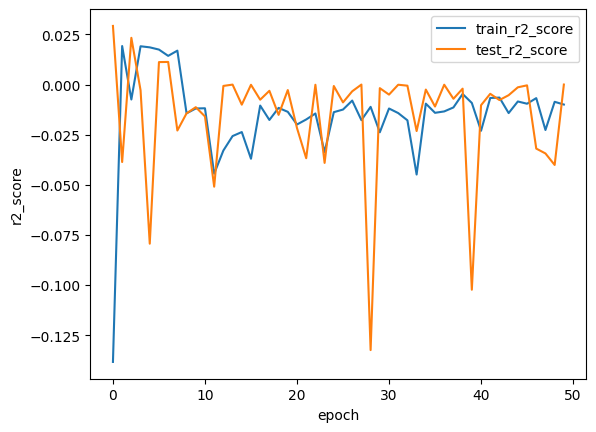

In [ ]:
def show_history(story):
    plt.plot(story.history['r2_score'])
    plt.plot(story.history['val_r2_score'])
    plt.ylabel('r2_score')
    plt.xlabel('epoch')
    plt.legend(['train_r2_score', 'test_r2_score'], loc='best')
    plt.show()

show_history(story)

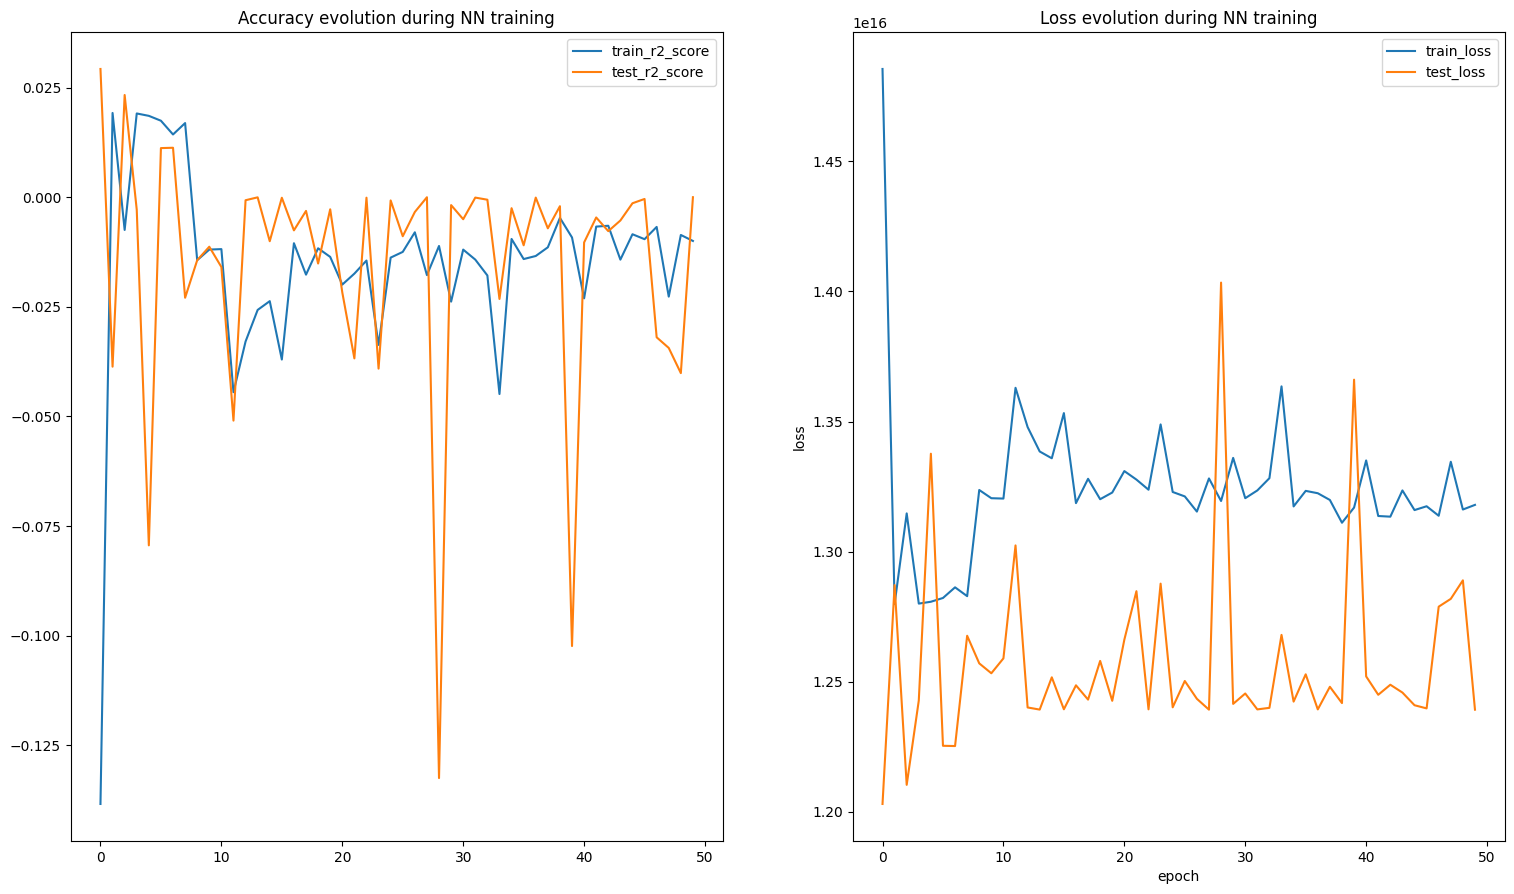

In [ ]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['r2_score'])
    ax1.plot(story.history['val_r2_score'])
    ax1.legend(['train_r2_score', 'test_r2_score'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()

show_history(story)

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=(X.shape[1],)))
model.add(layers.Dense(nb_units,  #number of neurons
                activation='relu',  #activation function
                kernel_initializer=keras.initializers.he_normal(seed=seed),  #initialisation of weights; check doc for more options
                 #initialization of biases, will also be done by default
                ))
model.add(BatchNormalization())
# One more layer with the same configuration
model.add(layers.Dense(nb_units, activation='relu'))#, kernel_initializer=keras.initializers.he_normal(seed=seed))) 
model.add(BatchNormalization())
model.add(layers.Dense(nb_units, activation='relu'))#, kernel_initializer=keras.initializers.he_normal(seed=seed))) 
#model.add(BatchNormalization())
model.add(layers.Dense(1)) 
#model.add(BatchNormalization())
learning_rate=0.15
decay_rate = learning_rate / epochs
momentum = 0.08
opt = keras.optimizers.SGD(learning_rate=learning_rate, decay=decay_rate, momentum=momentum, nesterov=False) # there are many more parameters that we could be adding here

# Calling compile and specifying some mandatory arguments completes setting up the NN
model.compile(optimizer=opt, loss='mse', metrics=['r2_score'])
model.summary()

batch_size = 15 #1 for online SGD
epochs = 50

#And now we fit the model (that is the training part), mind that saving it to the 
# variable will help you retrieve and analyse the training history
story = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test) #OR validation_split=0.3
)

c:\Users\user\Desktop\UNI\Python\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 128)            │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,393 (294.50 KB)

 Trainable params: 74,881 (292.50 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: inf - r2_score: -0.0094 - val_loss: 12434561682112512.0000 - val_r2_score: -0.0034
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12187634348589056.0000 - r2_score: -0.0191 - val_loss: 13174989347880960.0000 - val_r2_score: -0.0631
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11406002914066432.0000 - r2_score: -0.0216 - val_loss: 14041229490651136.0000 - val_r2_score: -0.1330
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14788394886365184.0000 - r2_score: -0.0275 - val_loss: 12639048296300544.0000 - val_r2_score: -0.0199
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11456194975629312.0000 - r2_score: -0.0112 - val_loss: 12410504496545792.0000 - val_r2_score: -0.0015
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11545209246580736.0000 - r2_score: -0.0198 - val_loss: 12884911551676416.0000 - val_r2_score: -0.0397
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1

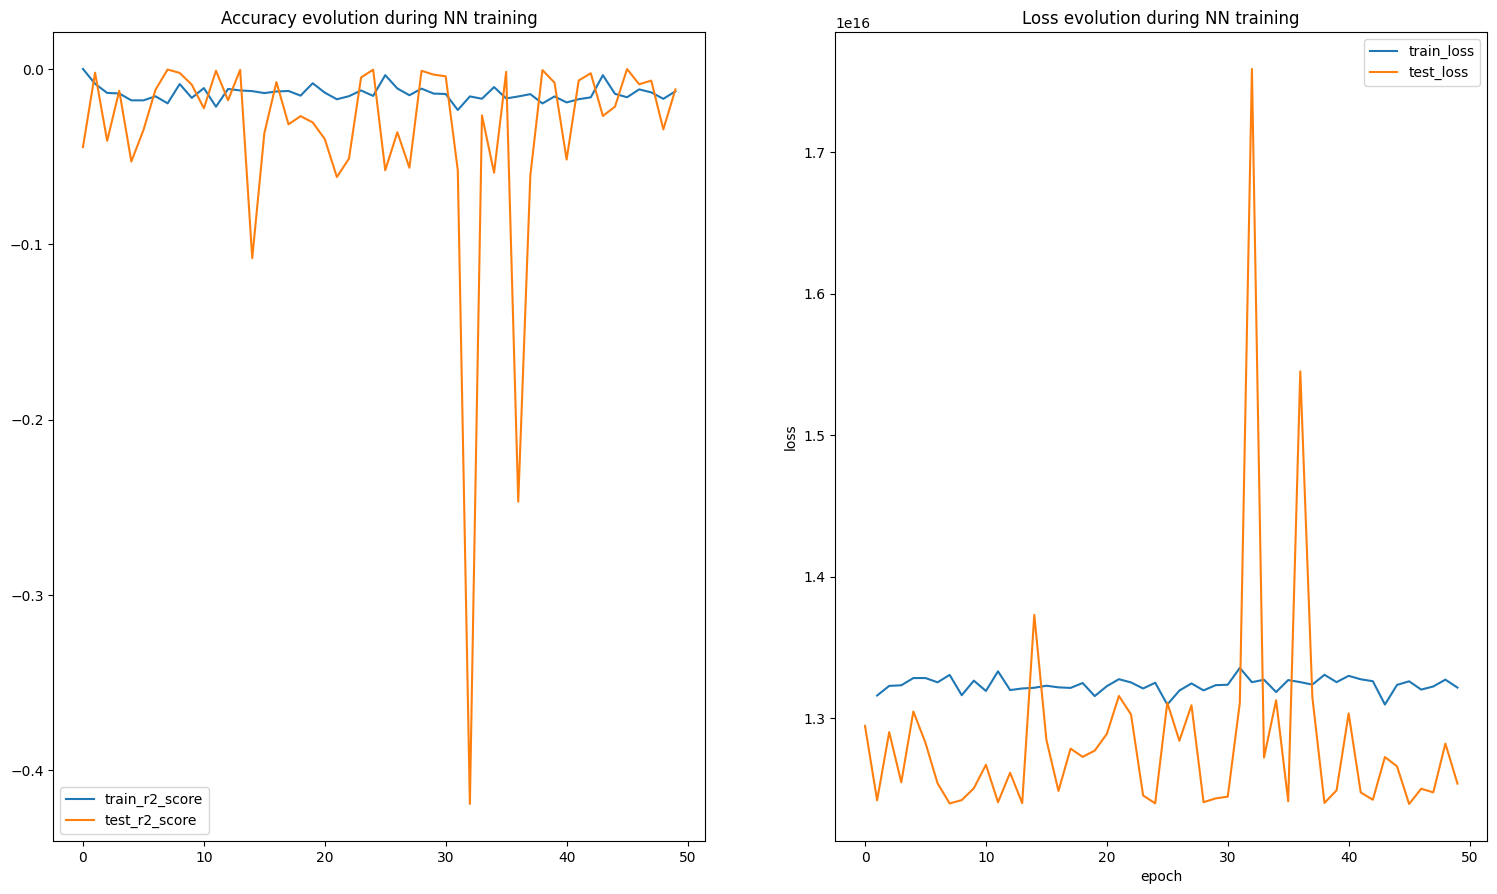

In [ ]:
def show_history(story):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18.5, 10.5)
    ax1.plot(story.history['r2_score'])
    ax1.plot(story.history['val_r2_score'])
    ax1.legend(['train_r2_score', 'test_r2_score'], loc='best')
    ax1.set_title('Accuracy evolution during NN training')
    
    ax2.plot(story.history['loss'])
    ax2.plot(story.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(['train_loss', 'test_loss'], loc='best')
    ax2.set_title('Loss evolution during NN training')
    plt.show()

show_history(story)